# **AWL**

## 1. Business Understanding

Het doel van deze themaopdracht is om het materiaal (papier, plastic karton) en vorm (zak, envelop, doos) van een pakket te kunnen classificeren op basis van de aangeleverde afbeeldingen.

De vragen die wij willen beantwoorden:
- Wat zijn de limitaties van de huidige dataset met betrekking tot de genoemde categorieën?
- Zijn er suggesties over de acquisitie van de data (opname, belichting)

Segmenteer de pakketten (handmatig of met AI) en classificeer een uitsnede van een pakket wat  betreft het materiaal en/of vorm.

Denk na over:
- Wat zijn de limitaties van de huidige dataset met betrekking tot de genoemde categorieën?
- Heb je suggesties over de acquisitie van de data (opname, belichting)


Dataset op teams:
- Ca 1000 afbeeldingen met 1 of meer pakketjes
- Yaml-bestanden met daarin o.a. het door het commerciële systeem geschatte label van en locatie 
van de objecten op de foto
- Optioneel: bin bestanden met daarin een segmentatie masker


obv de [video](https://www.youtube.com/watch?v=mgKt8KxWQZQ), moet de volgende stap weten hoe hard hij moet zuigen aan het pakketje

## 2. Data Understanding
De aangeleverde data van AWL bestaat uit een folder met 1155 log subfolders. 

Elke log folder bevat: 
- afbeelding van de band met pakketten
- yaml bestand met informatie over de locatie van deze pakketten
- detection_bin bestand per gedetecteerd pakket


### Aanpak
- PNG en YAML-bestanden inlezen
- Overlay maken met de bounding boxes van de YAML-bestanden
- PNG-bestanden uitsnijden obv de labels in de YAML
- Locaties gebruiken we om te bepalen wat voor pakketje en welk materiaal het is

### Importeren van de libraries

In [7]:
# !pip install opencv-python

In [28]:
import os
import cv2
import yaml
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import regularizers, layers
from keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Yaml bestand inlezen

Zie bestand [logs/2022-04-21_13-39-09.506268_000029/2022-04-21_13-39-09.yaml](logs/2022-04-21_13-39-09.506268_000029/2022-04-21_13-39-09.yaml)

In [9]:
path_to_yaml = "logs/2022-04-21_13-39-09.506268_000029/2022-04-21_13-39-09.yaml"

with open(path_to_yaml, 'r') as file:
    data = yaml.safe_load(file)# Gevonden pakketen uit yaml halen

data

[{'created': datetime.datetime(2022, 4, 21, 13, 39, 9, 506408)},
 {'Client request ID': 18},
 {'received_pick_extensions': ['SimulatedWallsLayoutMessage']},
 {'server status is recording': datetime.datetime(2022, 4, 21, 13, 39, 9, 506739)},
 {'Sending status_update update.': datetime.datetime(2022, 4, 21, 13, 39, 9, 506761)},
 {'camera_op received image update.': datetime.datetime(2022, 4, 21, 13, 39, 9, 552687)},
 {'detection_called': datetime.datetime(2022, 4, 21, 13, 39, 9, 552792)},
 {'rgb': '2022-04-21_13-39-09.552741_rgb.png'},
 {'detection_finished': datetime.datetime(2022, 4, 21, 13, 39, 9, 611191)},
 {'server status is processing': datetime.datetime(2022, 4, 21, 13, 39, 9, 765249)},
 {'Sending status_update update.': datetime.datetime(2022, 4, 21, 13, 39, 9, 765279)},
 {'camera_op received cloud update.': datetime.datetime(2022, 4, 21, 13, 39, 9, 791649)},
 {'cloud': '2022-04-21_13-39-09.791697_cloud.pcd'},
 {'ensenso_op_finished': datetime.datetime(2022, 4, 21, 13, 39, 9, 791

### Alleen de gedetecteerde pakketten uit de yaml file halen

In [10]:
sorted_object_detections = data[19]["sorted_object_detections"]
sorted_object_detections

[{'label': 0,
  'label_name': 0,
  'score': 0.999776065,
  'box': {'minimum': [429, 445], 'maximum': [863, 783]},
  'detection_id': 0,
  'prioritization_score': 0.7166907815146102,
  'segmentation_size': 107576,
  'image_width': 1944,
  'image_height': 1200,
  'roi': [[353, 0], [1343, 0], [1580, 1200], [180, 1200]],
  'centroid': [0.9149736166000366, 0.18296970427036285, -0.5753913521766663],
  'normalized_distance_from_center_to_center': 0.255078745228656,
  'normalized_segmentation_size': 0.27366594275030903,
  'roi_center': [864.9145945230943, 634.3385475443732],
  'mask_center': [634.3384026176842, 603.9313973376961]},
 {'label': 0,
  'label_name': 0,
  'score': 0.999921679,
  'descriptors': {'shapes': {'box': 0.999997139,
    'bag': 2.25283273e-07,
    'envelope': 2.61329296e-06,
    'cylinder': 1.39270359e-29,
    'undefined': 1.24990196e-08},
   'materials': {'cardboard': 0.999981284,
    'paper': 1.71743886e-05,
    'soft-plastic': 1.56716692e-06,
    'hard-plastic': 5.60106952

### Beschrijving van de data
Hieronder een beschrijving van de verschillende velden:

**label**: Dit is het label van het gedetecteerde object. In dit geval is het label 0.

**label_name**: Dit is de naam van het label. Hier is het ook 0, wat kan betekenen dat er geen specifieke naam is toegewezen.

**score**: Dit is de waarschijnlijkheidsscore van de detectie, wat aangeeft hoe zeker het model is over de detectie.

**descriptors**:
  - **shapes**: box, bag, envelope, cylinder, undefined
  - **materials**: cardboard, paper, soft-plastic, hard-plastic, metal, glass,
          undefined
  - **occlusion**: foreground, background
   
Deze sectie bevat beschrijvingen van het object, zoals de vorm, het materiaal en de occlusie (voorgrond/achtergrond).

**box**:
  - **minimum**
  - **maximum**

De coördinaten van de minimale en maximale punten van de bounding box rond het gedetecteerde object.

**detection_id**: Een unieke identificatie voor deze specifieke detectie.

**prioritization_score**: ?

**segmentation_size**: De grootte van het gesegmenteerde gebied.

**image_width**: De breedte van de afbeelding 

**image_height**: De hoogte van de afbeelding

**roi**: De coördinaten van de Region of Interest in de afbeelding.

**centroid**: ? 

**normalized_distance_from_center_to_center**: De genormaliseerde afstand van het centrum van het object tot het centrum van de afbeelding.

**normalized_segmentation_size**: De genormaliseerde grootte van het gesegmenteerde gebied.

**roi_center**: De coordinaten van het centrum van de ROI.

**mask_center**: De coordinaten van het centrum van het masker van het object.

In [11]:
sorted_object_detections[0]['box']

{'minimum': [429, 445], 'maximum': [863, 783]}

### Locaties van de pakketten weergeven op afbeelding

/var/folders/g_/05t9yvy52y731p3lghybrmbr0000gn/T/ipykernel_28901/2002005514.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('hsv', len(sorted_object_detections) + 1)


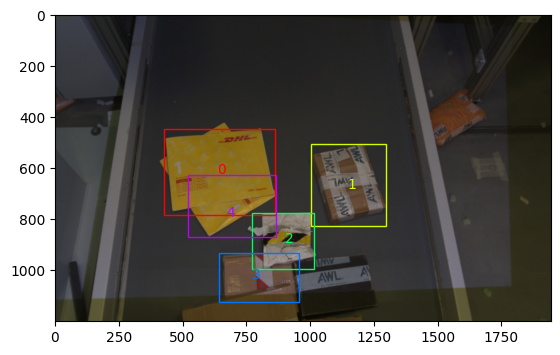

In [12]:
afbeelding1 = cv2.imread("logs/2022-04-21_13-39-09.506268_000029/2022-04-21_13-39-09.552741_rgb.png")
afbeelding1 = cv2.cvtColor(afbeelding1, cv2.COLOR_BGR2RGB)

plt.imshow(afbeelding1)

colors = plt.cm.get_cmap('hsv', len(sorted_object_detections) + 1)

for (index, label) in enumerate(sorted_object_detections):
    color = colors(index)
    box = label['box']

    center_x = label['mask_center'][0]
    center_y = label['mask_center'][1]

    min_x = box['minimum'][0]
    min_y = box['minimum'][1]
    max_x = box['maximum'][0]
    max_y = box['maximum'][1]

    width = max_x - min_x
    height = max_y - min_y

    plt.gca().add_patch(
        Rectangle(
            (min_x, min_y),
            width, height,
            edgecolor=color,
            facecolor='none',
            lw=1)
    )

    plt.text(center_x, center_y, str(index), color=color, fontsize=10, horizontalalignment='left', verticalalignment='center')

plt.show()

## 3. Data Preparation
In de data preparation fase gaan we alle afbeeldingen samenvoegen, uitsnijden en voorzien van labels.

### 3.1. Inladen van de afbeeldingen

In [13]:
# Load images and YAML
def load_image_and_yaml(image_path, yaml_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (256, 256))
    with open(yaml_path, 'r') as file:
        yamldata = yaml.safe_load(file)
    return image, yamldata

images = []
yamls = []

# TODO change base_path to general path that works for everyone?
base_path = 'logs/'

for folder in os.listdir(base_path):
    image_path = glob.glob(os.path.join(base_path, folder, '**', '*.png'), recursive=True)[0]
    yaml_path = base_path + folder + '/' + folder.split('.')[0] + '.yaml'
    image, yamldata = load_image_and_yaml(image_path, yaml_path)
    images.append(image)
    yamls.append(yamldata)

### 3.2. Uitsnijden van images obv de labels

In [14]:
widths = []
heights = []

for Yet_Another_Markup_Language in yamls:
    for entry in Yet_Another_Markup_Language:
        if 'sorted_object_detections' not in entry:
            continue

        if type(entry['sorted_object_detections']) is not list:
            continue

        for label in entry['sorted_object_detections']:
            box = label['box']

            center_x = label['mask_center'][0]
            center_y = label['mask_center'][1]

            min_x = box['minimum'][0]
            min_y = box['minimum'][1]
            max_x = box['maximum'][0]
            max_y = box['maximum'][1]

            width = max_x - min_x
            height = max_y - min_y

            widths.append(width)
            heights.append(height)

print("Aantal widths=", len(widths), "Aantal heights=", len(heights))

print(f'Width = {np.mean(widths)} of {np.std(widths)} (min = {np.min(widths)}, max = {np.max(widths)})')
print(f'Height = {np.mean(heights)} of {np.std(heights)} (min = {np.min(heights)}, max = {np.max(heights)})')

# OUTPUT:
#   Aantal widths= 4936 Aantal heights= 4936
#   Width = 352.7678282009725 of 93.23155234325732 (min = 81, max = 666)
#   Height = 328.9961507293355 of 92.18500939757202 (min = 41, max = 713)

Aantal widths= 4936 Aantal heights= 4936
Width = 352.7678282009725 of 93.23155234325732 (min = 81, max = 666)
Height = 328.9961507293355 of 92.18500939757202 (min = 41, max = 713)


Een goeie size is dan ongeveer $96\times{96}$ pixels.

We hebben 4935 parcels geladen uit 1155 yamls en 1155 images
Sizes {'descriptors': {'shapes': {'box': 0.000459799223, 'bag': 0.993329823, 'envelope': 0.0050109257, 'cylinder': 2.60664645e-13, 'undefined': 0.00119943568}, 'materials': {'cardboard': 0.000249604724, 'paper': 0.000514074869, 'soft-plastic': 0.997243285, 'hard-plastic': 1.31846631e-27, 'metal': 7.00649232e-45, 'glass': 0, 'undefined': 0.00199304707}, 'occlusion': {'foreground': 0.0289920047, 'background': 0.971008003}}, 'min_x': 113, 'max_x': 175, 'min_y': 0, 'max_y': 67, 'img_path': '2022-04-22_06-28-10.719677_rgb.png'}
Shape: (64, 64, 3)


{'descriptors': {'shapes': {'box': 0.000459799223,
   'bag': 0.993329823,
   'envelope': 0.0050109257,
   'cylinder': 2.60664645e-13,
   'undefined': 0.00119943568},
  'materials': {'cardboard': 0.000249604724,
   'paper': 0.000514074869,
   'soft-plastic': 0.997243285,
   'hard-plastic': 1.31846631e-27,
   'metal': 7.00649232e-45,
   'glass': 0,
   'undefined': 0.00199304707},
  'occlusion': {'foreground': 0.0289920047, 'background': 0.971008003}},
 'min_x': 113,
 'max_x': 175,
 'min_y': 0,
 'max_y': 67,
 'img_path': '2022-04-22_06-28-10.719677_rgb.png'}

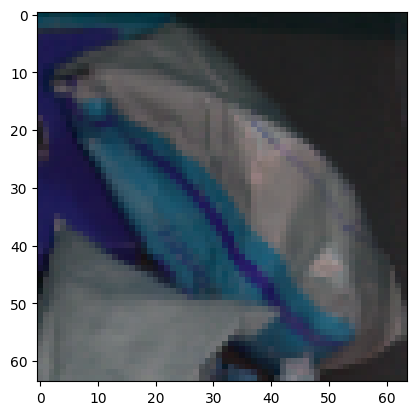

In [16]:
parcels = []

for (Yet_Another_Markup_Language, img) in zip(yamls, images):
    for entry in Yet_Another_Markup_Language:
        if 'sorted_object_detections' not in entry:
            continue

        if type(entry['sorted_object_detections']) is not list:
            continue

        for label in entry['sorted_object_detections']:
            if not 'descriptors' in label:
                continue

            box = label['box']

            factor_x = label['image_width'] / img.shape[0]
            factor_y = label['image_height'] / img.shape[1]

            min_x = int(box['minimum'][0] / factor_x)
            min_y = int(box['minimum'][1] / factor_y)
            max_x = int(box['maximum'][0] / factor_x)
            max_y = int(box['maximum'][1] / factor_y)

            img_path = '(onbekend)'
            for x in Yet_Another_Markup_Language:
                if 'rgb' in x:
                    img_path = x['rgb']

            cut_out = img[min_y:max_y, min_x:max_x]
            cut_out = cv2.resize(cut_out, (64, 64))

            parcels.append({
                'image': cut_out,
                'metadata': {
                    'descriptors': label['descriptors'],
                    'min_x': min_x,
                    'max_x': max_x,
                    'min_y': min_y,
                    'max_y': max_y,
                    'img_path': img_path,
                }
            })


print(f"We hebben {len(parcels)} parcels geladen uit {len(yamls)} yamls en {len(images)} images")

parcel1 = parcels[0]
print(f'Sizes {parcel1["metadata"]}')
test_img = parcel1['image']
print("Shape:", test_img.shape)

plt.imshow(parcel1['image'])

parcel1['metadata']

In [50]:

widths = []
heights = []
for parcel in parcels:
    widths.append(parcel['image'].shape[0])
    heights.append(parcel['image'].shape[1])

print("Aantal widths=", len(widths), "Aantal heights=", len(heights))

print(f'Width = {np.mean(widths)} of {np.std(widths)} (min = {np.min(widths)}, max = {np.max(widths)})')
print(f'Height = {np.mean(heights)} of {np.std(heights)} (min = {np.min(heights)}, max = {np.max(heights)})')

Aantal widths= 4936 Aantal heights= 4936
Width = 70.18253646677472 of 19.6964841012002 (min = 8, max = 152)
Height = 46.46110210696921 of 12.273412545476267 (min = 10, max = 88)


### 3.3. Normaliseren van de label_images

In [ ]:
# Normalize
for image in images:
    image = image / 255.0


In [52]:
# Using hashmaps for labels (training model works better with integers than strings)
# TODO ? Check if Tensorflow already picks only indexes from arrays to check labels which renders this step unnecessary
# Add undefined for training or not?
material_map = {'cardboard': 0, 'paper': 1, 'soft-plastic': 2 , 'hard-plastic': 3, 'metal': 4, 'glass': 5, 'undefined': 6}
shape_map = {'box': 0, 'bag': 1, 'envelope': 2, 'cylinder': 3, 'undefined': 4}


material_labels = []
shape_labels = []

shape_classes = ['box', 'bag', 'envelope', 'cylinder']
material_classes = ['cardboard', 'paper', 'soft-plastic', 'metal', 'glass']

cut_outs = []
labels = []

for parcel in parcels:
    cut_outs.append(parcel['image'])
    labels.append((
            round(parcel['metadata']['descriptors']['shapes']['box']),
            round(parcel['metadata']['descriptors']['shapes']['bag']),
            round(parcel['metadata']['descriptors']['shapes']['envelope']),
            round(parcel['metadata']['descriptors']['shapes']['cylinder']),

            round(parcel['metadata']['descriptors']['materials']['cardboard']),
            round(parcel['metadata']['descriptors']['materials']['paper']),
            round(parcel['metadata']['descriptors']['materials']['soft-plastic']),
    ))

cut_outs = np.array(cut_outs)
labels = np.array(labels)
print("CutOuts:", cut_outs.shape[1:])
print("Labels:", labels.shape)

CutOuts: (64, 64, 3)
Labels: (4935, 7)


### 3.4. Maken van validation data

### 3.5. Opschonen van onbruikbare labels
- Te kleine images
- etc.

## 4. Modeling

### 4.1. Opsplitsen van train- en testdata

In [40]:
train_images, test_images, train_labels, test_labels = train_test_split(cut_outs, labels, test_size=0.2, random_state=42)

### 4.2. Variatie maken in de data

### 4.3. Opzetten van het model

In [44]:
inputs = keras.Input(shape=cut_outs.shape[1:])

x = Conv2D(16, (3, 3), activation='relu')(inputs)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.4)(x)

output = layers.Dense(labels.shape[1], activation='sigmoid', name='material_output')(x)


# Bouw keras model met functionele API, voor alleen de material
model = keras.Model(inputs=inputs, outputs=[output])

# keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 62, 62, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 62, 62, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 62, 62, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 30752)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │       984,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ material_output (Dense)         │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 999,049 (3.81 MB)

 Trainable params: 998,889 (3.81 MB)

 Non-trainable params: 160 (640.00 B)

### 4.4. Model fitten

In [46]:
model.compile(optimizer="ADAM",
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              #   loss="categorical_crossentropy",
              metrics=["accuracy"])

In [47]:
history = model.fit(
    train_images,
    train_labels,
    # batch_size=32,
    epochs=100,
    validation_data=(test_images, test_labels),
)

Epoch 1/100


/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-09-25 12:00:13.543060: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.3919 - loss: 0.6132 - val_accuracy: 0.2340 - val_loss: 0.5605
Epoch 2/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.5304 - loss: 0.3853 - val_accuracy: 0.5846 - val_loss: 0.3706
Epoch 3/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.5673 - loss: 0.2952 - val_accuracy: 0.6575 - val_loss: 0.4102
Epoch 4/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.6498 - loss: 0.2636 - val_accuracy: 0.3678 - val_loss: 0.6000
Epoch 5/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.6373 - loss: 0.2558 - val_accuracy: 0.4600 - val_loss: 1.4553
Epoch 6/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6307 - loss: 0.2478 - val_accuracy: 0.7599 - val_loss: 0.2388
Epoch 7/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6823 - loss: 0.1978 - val_accuracy: 0.5927 - val_loss: 0.1836
Epoch 8/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.6328 - loss: 0.1912 - val_accuracy

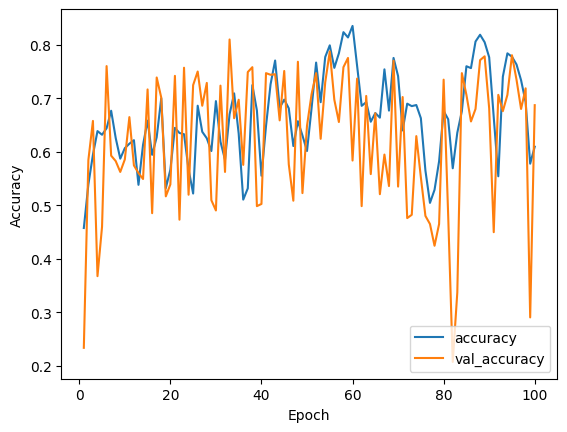

In [48]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=range(1, len(acc)+1)
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

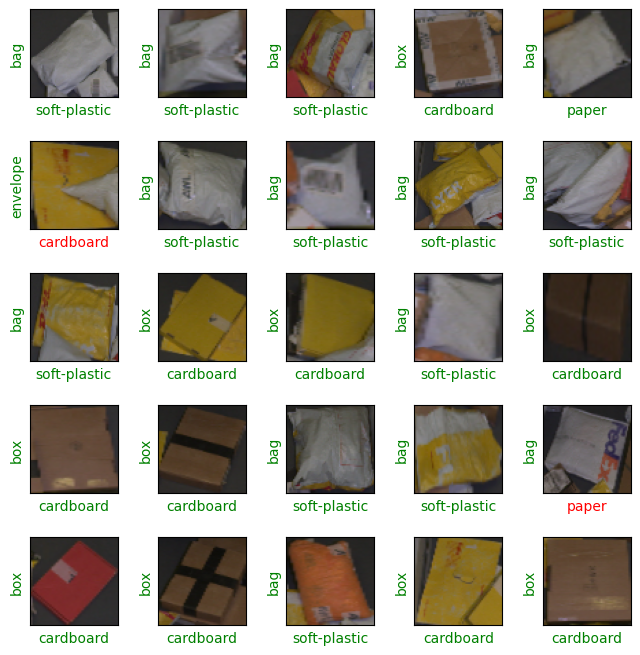

In [62]:
def collectPrediction(prediction):
    return {
        'shape': shape_classes[np.argmax(prediction[0:len(shape_classes)])],
        'material': material_classes[np.argmax(prediction[len(shape_classes):])],
    }

def predictShapeAndMaterial(image):
    prediction = model.predict(image, verbose=0)[0]
    return collectPrediction(prediction)

predictShapeAndMaterial(test_images[0:1])

fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0.5)

for i in range(0, 25):
    ax = plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
     #orginele plaatjes nodig want de rest zit in een genormaliseerde vector
    plt.imshow(train_images[i][...,::-1])

    predict = predictShapeAndMaterial(train_images[i:i+1])
    actual = collectPrediction(train_labels[i])

    plt.xlabel(predict['material'])
    ax.xaxis.label.set_color('green' if actual['material'] == predict['material'] else 'red')

    plt.ylabel(predict['shape'])
    ax.yaxis.label.set_color('green' if actual['shape'] == predict['shape'] else 'red')

plt.show()

## 5. Evaluation

## 6. Conclusie

Als je zekerheid van een "detection"-stap te laag is voor een bepaald pakketje, zet het model dan ook in voor foto's aan de zijkanten.